In [1]:
# pip instal pytorch-lightning

In [2]:
import os

import numpy as np
import cv2
# from PIL import Image
# from IPython.display import display, Image
import matplotlib.pyplot as plt
import random


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

import pytorch_lightning as pl


In [3]:
torch.cuda.device_count()

0

In [4]:
BATCH_SIZE = 5
AVAIL_GPUS = min(1, torch.cuda.device_count())
AVAIL_GPUS

0

In [5]:
Train_Folder ='./Dataset/Train/'
image_files= [f for f in os.listdir(Train_Folder) if f.endswith('.jpg')]


In [6]:
sketch_list = []
image_list = []

def generate_image(image_path):
    og_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    n_image = cv2.resize(og_image, (128, 128))
    n_image = n_image/255.0
    return n_image

def generate_outline(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    n_image = cv2.resize(image, (256, 256))
    blurred = cv2.GaussianBlur(n_image, (3, 3), 1)
    edges = cv2.Canny(blurred, 30, 60)
    inverted_edges = cv2.bitwise_not(edges)
    resized_image = cv2.resize(inverted_edges, (128, 128))
    gray_image_final = resized_image/255.0
    gray_image_final = np.expand_dims(gray_image_final, axis=-1)
    return gray_image_final

for image_file in image_files:
    image_path = os.path.join(Train_Folder, image_file)
    image_list.append(generate_image(image_path))
    sketch_list.append(generate_outline(image_path))
    
sketch_list[1].shape

(128, 128, 1)

In [7]:
image_list[1].shape

(128, 128, 3)

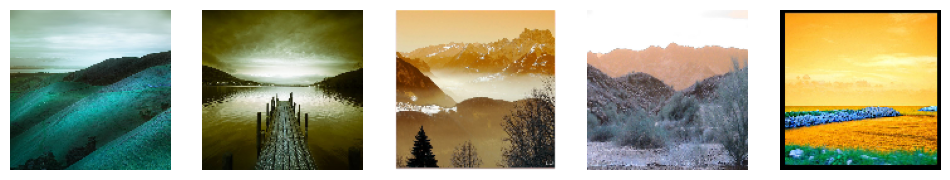

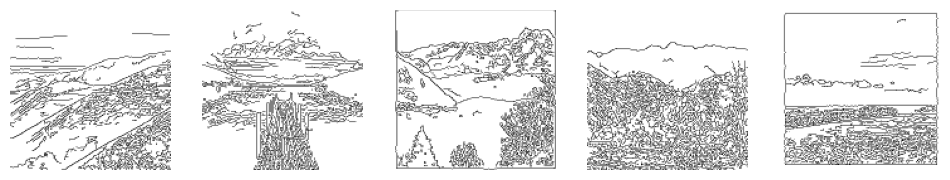

In [8]:
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image_list[i], cmap='gray')
    plt.axis('off')
plt.show()
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sketch_list[i], cmap='gray')
    plt.axis('off')
plt.show()

In [9]:

class ImageSketchDataset(Dataset):
    def __init__(self, images, sketches, transform=None):
        self.images = images
        self.sketches = sketches
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        sketch = self.sketches[idx]
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
            sketch = self.transform(sketch)
        
        return {'image': image, 'sketch': sketch}

# Convert images and sketches to PyTorch tensors
transform = ToTensor()

# Create the dataset
dataset = ImageSketchDataset(image_list, sketch_list, transform=transform)

# Create the DataLoader
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

In [10]:
sketch_to_gen = []
for sketch in sketch_list:
    sketch_to_gen.append(transform(sketch))
sketch_to_gen

[tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.5020, 0.5020, 0.7490,  ..., 0.7490, 0.5020, 1.0000],
          [1.0000, 1.0000, 0.7490,  ..., 0.7490, 0.5020, 0.7490],
          [1.0000, 1.0000, 1.0000,  ..., 0.5020, 0.5020, 0.5020]]],
        dtype=torch.float64),
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], dtype=torch.float64),
 tensor([[[1.0000, 1.0000, 0.7490,  ..., 0.5020, 0.7490, 1.0000],
          [0.5020, 0.5020, 0.7490,  ..., 1.0000, 0.7490, 0.2510],
          [0.5020, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.5020],
          ...,
          [1.0000, 0.5020, 1.0000,  ..., 1.0000, 1.00

In [11]:
for batch in dataloader:
    images = batch['image']
    sketches = batch['sketch']
    print('Batch of images shape:', images.shape)
    print('Batch of sketches shape:', sketches.shape)
    break

Batch of images shape: torch.Size([2, 3, 128, 128])
Batch of sketches shape: torch.Size([2, 1, 128, 128])


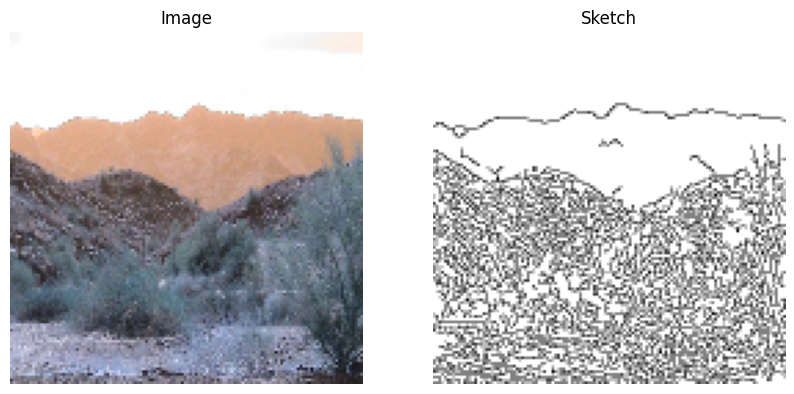

In [12]:
for batch in dataloader:
    images = batch['image']
    sketches = batch['sketch']
    break

# Select the first image and sketch from the batch
image = images[0].numpy().transpose(1, 2, 0)  # Convert from CHW to HWC format
sketch = sketches[0].numpy().squeeze()  # Remove single-channel dimension if necessary

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Display the image
ax[0].imshow(image)
ax[0].set_title('Image')
ax[0].axis('off')

# Display the sketch
ax[1].imshow(sketch, cmap='gray')
ax[1].set_title('Sketch')
ax[1].axis('off')

plt.show()

In [13]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=4, stride=1, padding=2)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(64*32*32, 2048)
        self.fc2 = nn.Linear(2048,50)
        self.fc3 = nn.Linear(50,1)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 64*32*32)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)

        return torch.sigmoid(x)



In [15]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.ct1 = nn.ConvTranspose2d(1, 64, kernel_size=4, stride=2, padding=1)  # Output: [64, 64, 64]
        self.ct2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)  # Output: [32, 128, 128]
        self.ct3 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)  # Output: [16, 256, 256]
        self.ct4 = nn.ConvTranspose2d(16, 3, kernel_size=4, stride=1, padding=1)   # Output: [3, 128, 128]
        
    def forward(self, x):
        # Forward pass through the network
        x = F.relu(self.ct1(x))  # Shape: [batch_size, 64, 64, 64]
        x = F.relu(self.ct2(x))  # Shape: [batch_size, 32, 128, 128]
        x = F.relu(self.ct3(x))  # Shape: [batch_size, 16, 256, 256]
        x = self.ct4(x)         # Shape: [batch_size, 3, 128, 128]
        return torch.tanh(x)    # Use Tanh for the final output


In [16]:
class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002):
        super().__init__()
        self.save_hyperparameters()
        self.generator = Generator()
        self.discriminator = Discriminator()

    def forward(self, z):
        return self.generator(z)
    
    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        global sketch_to_gen
        real_imgs = batch['image'].to(self.device)
        z = random.choice(sketch_to_gen)
        z = z.unsqueeze(0)
        z = z.to(torch.float32)

        if optimizer_idx == 0:
            fake_imgs = self(z)
            y_hat = self.discriminator(fake_imgs)
            y = torch.ones(real_imgs.size(0),1)
            # y = y.type_as(real_imgs)

            g_loss = self.adversarial_loss(y_hat, y)
            
            log_dict = {"g_loss": g_loss}
            return {"loss":g_loss, "progress_bar":log_dict, "log":log_dict}

        if optimizer_idx == 1:
            y_hat_real = self.discriminator(real_imgs)
            y_real = torch.ones(real_imgs.size(0),1)
            # y_real = y_real.type_as(real_imgs)

            real_loss = self.adversarial_loss(y_hat_real, y_real)
            
            y_hat_fake = self.discriminator(self(z).detach())

            y_fake = torch.zeros(real_imgs.size(0),1)
            # y_fake = y_fake.type_as(real_imgs)

            fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

            d_loss = (real_loss + fake_loss)/2

            log_dict = {"d_loss": d_loss}
            return {"loss":d_loss, "progress_bar":log_dict, "log":log_dict}


    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        return [opt_g, opt_d], []
    
    def plot_imgs(self, dataloader):
        global sketch_to_gen
        z = random.choice(sketch_to_gen)
        print(z)
        z = z.unsqueeze(0)
        z = z.to(torch.float32)
        sample_imgs = self(z).cpu()  # Generate images and move to CPU

        print('epoch ', self.current_epoch)
        fig = plt.figure()
        for i in range(sample_imgs.size(0)):
            plt.subplot(2, 3, i+1)
            plt.tight_layout()
            plt.imshow(sample_imgs.detach()[i].permute(1,2,0), interpolation='none')
            plt.title("Generated Data")
            plt.xticks([])
            plt.yticks([])
            plt.axis('off')
        plt.show()
    
    def on_epoch_end(self):
        self.plot_imgs()

In [17]:
model = GAN()

tensor([[[1.0000, 1.0000, 0.7490,  ..., 0.5020, 0.7490, 1.0000],
         [0.5020, 0.5020, 0.7490,  ..., 1.0000, 0.7490, 0.2510],
         [0.5020, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.5020],
         ...,
         [1.0000, 0.5020, 1.0000,  ..., 1.0000, 1.0000, 0.5020],
         [1.0000, 0.2510, 0.5020,  ..., 0.5020, 0.2510, 0.5020],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]],
       dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15872587..0.16083558].


epoch  0


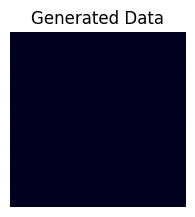

In [18]:
model.plot_imgs(dataloader)

In [19]:
# trainer = pl.Trainer(max_epochs=20, gpus=AVAIL_GPUS)
trainer = pl.Trainer(max_epochs=20)

trainer.fit(model,dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 42.9 K
1 | discriminator | Discriminator | 134 M 
------------------------------------------------
134 M     Trainable params
0         Non-trainable params
134 M     Total params
538.024   Total estimated model params size (MB)
c:\Users\kev70\anaconda3\envs\datascience\Lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\kev70\anaconda3\envs\datascience\Lib\site-packages\pytorch_lightning\trainer\data_loading.py:432: UserWarning: The number of training

Epoch 0:   0%|          | 0/5 [00:00<?, ?it/s] 

ValueError: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.